In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00


In [ ]:
!pip install torchsummary

In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision import models

from torchsummary import summary
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import SubsetRandomSampler
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
seed = 88
batch_size = 32
num_epochs = 20
learning_rate = 0.0001
dropout = 0.1
momentum = 0.9

num_classes = 3

In [ ]:
drive.mount('/content/drive')
# Define the path to the dataset
data_path = "/content/drive/MyDrive/dataset_project/X-Ray"

# Define the transformations to be applied to the images
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Modify the image size to a standardized 64x64
    transforms.ToTensor(),  # Transform the images into PyTorch tensor format
])

# Load the dataset using ImageFolder
dataset = ImageFolder(root=data_path, transform=data_transforms)

Mounted at /content/drive


In [ ]:
# Calculate the length of the dataset
dataset_length = len(dataset)
print("Length of the dataset:", dataset_length)

# Get the dictionary mapping class indices to their names
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Initialize a dictionary to store label counts
label_counts = {class_name: 0 for class_name in idx_to_class.values()}

# Count the number of images in each class
for target in dataset.targets:
    class_name = idx_to_class[target]
    label_counts[class_name] += 1

# Print the label counts
print("Label counts:")
for class_name, count in label_counts.items():
    print(f"{class_name}: {count} images")

Length of the dataset: 5228
Label counts:
COVID: 1626 images
NORMAL: 1802 images
PNEUMONIA: 1800 images


In [ ]:
# Define the ratios for splitting the dataset
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Initialize the StratifiedShuffleSplit instance
sss = StratifiedShuffleSplit(n_splits=1, train_size=train_ratio, test_size=val_ratio + test_ratio, random_state=seed)

# Create a list with the labels of your images
targets = [y for _, y in dataset]

# Split the data into train and (validation + test)
train_indices, val_test_indices = next(sss.split(targets, targets))

# Convert val_test_indices to a numpy array
val_test_indices = np.array(val_test_indices)

# Create a new targets array for stratification
stratify_targets = np.array(targets)[val_test_indices]

# Now use stratify_targets in the train_test_split function
val_indices, test_indices = train_test_split(val_test_indices, test_size=test_ratio / (val_ratio + test_ratio),
                                             random_state=seed, stratify=stratify_targets)

# Create subsets of the dataset using the indices
train_dataset = SubsetRandomSampler(train_indices)
val_dataset = SubsetRandomSampler(val_indices)
test_dataset = SubsetRandomSampler(test_indices)

# Create DataLoaders for training, testing, and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Train set length:", len(train_dataset))
print("Validation set length:", len(val_dataset))
print("Test set length:", len(test_dataset),"\n")

Train set length: 4182
Validation set length: 523
Test set length: 523 



In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.cnn_layer_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cnn_layer_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn_layer_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(2, 2)

        self.linear_layer_1 = nn.Linear(64 * 8 * 8, 2048)
        self.linear_layer_2 = nn.Linear(2048, 1024)
        self.linear_layer_3 = nn.Linear(1024, 512)
        self.linear_layer_4 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.cnn_layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.cnn_layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.cnn_layer_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.flatten(x)

        x = self.linear_layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear_layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear_layer_3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear_layer_4(x)
        return x

cnn_model = CNNModel(num_classes)
print(cnn_model)


CNNModel(
  (cnn_layer_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn_layer_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer_1): Linear(in_features=4096, out_features=2048, bias=True)
  (linear_layer_2): Linear(in_features=2048, out_features=1024, bias=True)
  (linear_layer_3): Linear(in_features=1024, out_features=512, bias=True)
  (linear_layer_4): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
# Create an instance of the modified NeuralNetwork
model = CNNModel(num_classes)

# Specify the input size
input_size = (3, 64, 64)  # (channels, height, width)

# Print the model summary
summary(model, input_size=input_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
           Dropout-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
              ReLU-6           [-1, 32, 32, 32]               0
           Dropout-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
          Dropout-11           [-1, 64, 16, 16]               0
        MaxPool2d-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
torch.cuda.empty_cache()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_sampler = SubsetRandomSampler(train_indices)
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
val_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    cnn_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss / len(val_dataloader))
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Validation Loss: {val_losses[-1]:.4f} | Validation Accuracy: {val_accuracies[-1]:.2f}%")

Epoch: 1/20 | Train Loss: 0.7292 | Train Accuracy: 65.81% | Validation Loss: 0.5100 | Validation Accuracy: 86.23%
Epoch: 2/20 | Train Loss: 0.3414 | Train Accuracy: 86.49% | Validation Loss: 0.2555 | Validation Accuracy: 91.59%
Epoch: 3/20 | Train Loss: 0.2343 | Train Accuracy: 91.01% | Validation Loss: 0.3365 | Validation Accuracy: 84.89%
Epoch: 4/20 | Train Loss: 0.2158 | Train Accuracy: 92.06% | Validation Loss: 0.1958 | Validation Accuracy: 94.07%
Epoch: 5/20 | Train Loss: 0.1790 | Train Accuracy: 93.04% | Validation Loss: 0.2215 | Validation Accuracy: 91.97%
Epoch: 6/20 | Train Loss: 0.1717 | Train Accuracy: 93.50% | Validation Loss: 0.1456 | Validation Accuracy: 95.98%
Epoch: 7/20 | Train Loss: 0.1575 | Train Accuracy: 94.43% | Validation Loss: 0.1725 | Validation Accuracy: 94.07%
Epoch: 8/20 | Train Loss: 0.1509 | Train Accuracy: 94.40% | Validation Loss: 0.1720 | Validation Accuracy: 94.46%
Epoch: 9/20 | Train Loss: 0.1297 | Train Accuracy: 95.62% | Validation Loss: 0.1665 | Va

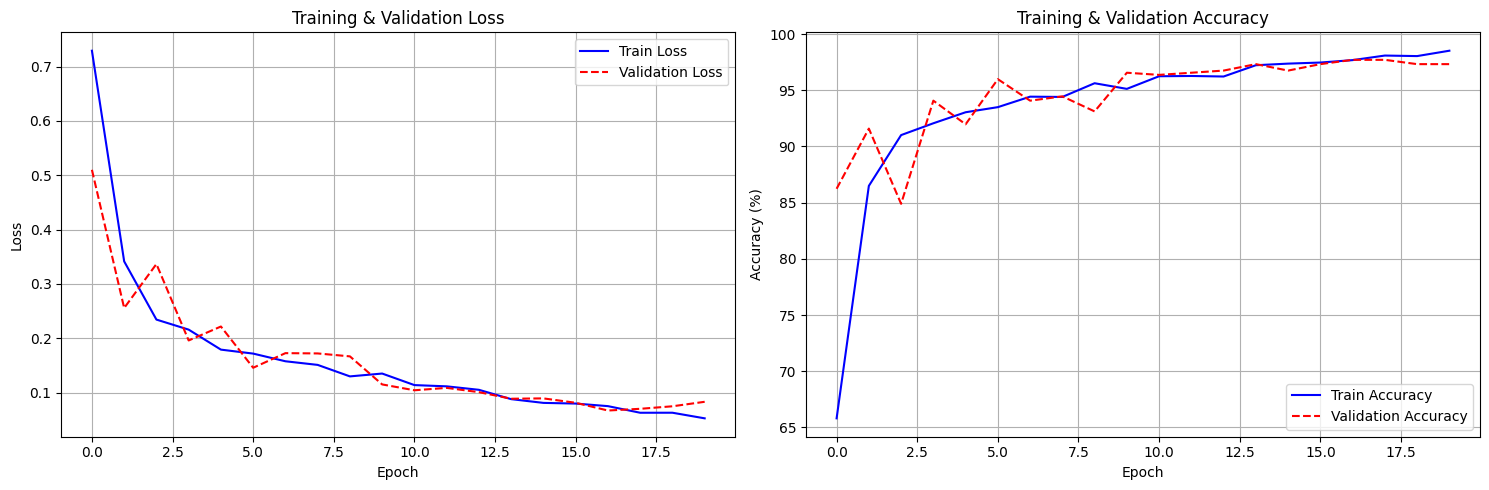

In [ ]:
# Set the size of the figure
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss')  # 'b-' specifies blue color, solid line
plt.plot(val_losses, 'r--', label='Validation Loss')  # 'r--' specifies red color, dashed line
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)  # Add gridlines for better readability
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Train Accuracy')
plt.plot(val_accuracies, 'r--', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Ensure a clean layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
cnn_model.eval()
true_labels = []
predicted_labels = []

test_sampler = SubsetRandomSampler(test_indices)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Batch Size: {batch_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Dropout: {dropout}")

print(f"Test Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")

Batch Size: 32
Number of Classes: 3
Learning Rate: 0.0001
Number of Epochs: 20
Dropout: 0.1
Test Accuracy: 0.959847
Precision: 0.960023
Recall: 0.959847
F1 Score: 0.959828


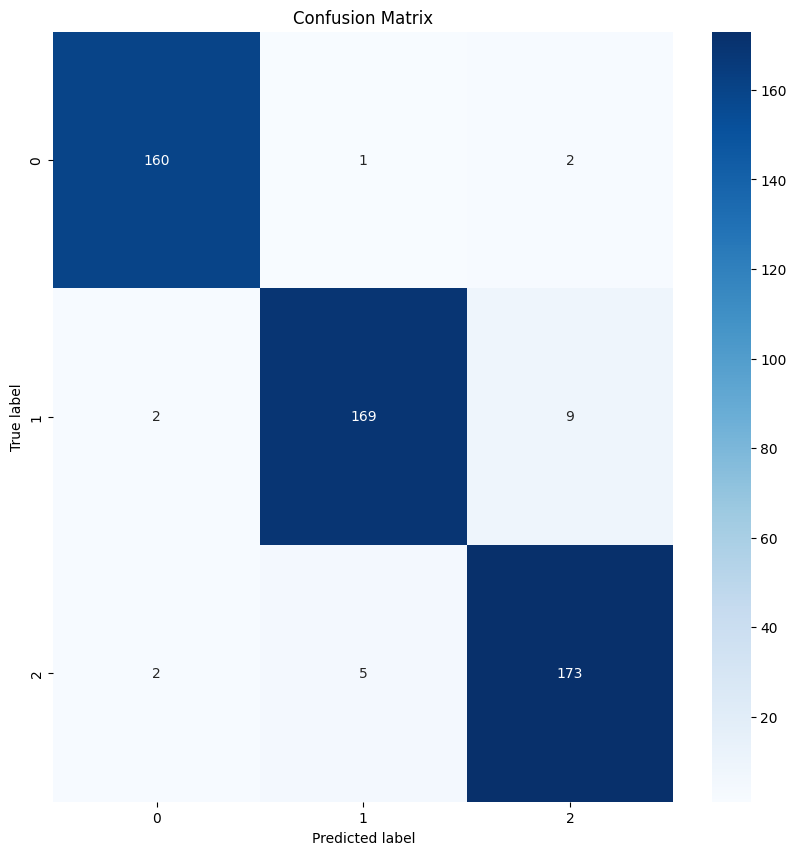

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
import torch
import torch.nn as nn

class HybridCNNBiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNBiLSTM, self).__init__()
        self.cnn_layer_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.cnn_layer_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn_layer_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.lstm = nn.LSTM(input_size=64*8*8, hidden_size=512, num_layers=2, batch_first=True, bidirectional=True)

        self.linear_layer_1 = nn.Linear(1024, 512)
        self.linear_layer_2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn_layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.cnn_layer_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        x = self.cnn_layer_3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.maxpool(x)

        batch_size = x.size(0)
        x = x.view(batch_size, -1, 64*8*8)

        x, _ = self.lstm(x)

        x = x[:, -1, :]

        x = self.linear_layer_1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear_layer_2(x)
        return x

model = HybridCNNBiLSTM(num_classes)
print(model)

HybridCNNBiLSTM(
  (cnn_layer_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn_layer_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn_layer_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(4096, 512, num_layers=2, batch_first=True, bidirectional=True)
  (linear_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (linear_layer_2): Linear(in_features=512, out_features=3, bias=True)
)


In [ ]:
torch.cuda.empty_cache()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_sampler = SubsetRandomSampler(train_indices)
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_indices)
val_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    cnn_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)

    # Validation loop
    cnn_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss / len(val_dataloader))
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.2f}% | "
          f"Validation Loss: {val_losses[-1]:.4f} | Validation Accuracy: {val_accuracies[-1]:.2f}%")

Epoch: 1/20 | Train Loss: 0.0652 | Train Accuracy: 97.90% | Validation Loss: 0.1144 | Validation Accuracy: 95.41%
Epoch: 2/20 | Train Loss: 0.0584 | Train Accuracy: 98.06% | Validation Loss: 0.1126 | Validation Accuracy: 95.98%
Epoch: 3/20 | Train Loss: 0.0498 | Train Accuracy: 98.54% | Validation Loss: 0.0567 | Validation Accuracy: 98.28%
Epoch: 4/20 | Train Loss: 0.0390 | Train Accuracy: 98.80% | Validation Loss: 0.0633 | Validation Accuracy: 97.71%
Epoch: 5/20 | Train Loss: 0.0329 | Train Accuracy: 99.09% | Validation Loss: 0.0758 | Validation Accuracy: 96.94%
Epoch: 6/20 | Train Loss: 0.0381 | Train Accuracy: 98.73% | Validation Loss: 0.0468 | Validation Accuracy: 98.66%
Epoch: 7/20 | Train Loss: 0.0275 | Train Accuracy: 99.14% | Validation Loss: 0.0855 | Validation Accuracy: 96.75%
Epoch: 8/20 | Train Loss: 0.0256 | Train Accuracy: 99.07% | Validation Loss: 0.0754 | Validation Accuracy: 97.13%
Epoch: 9/20 | Train Loss: 0.0374 | Train Accuracy: 98.47% | Validation Loss: 0.0927 | Va

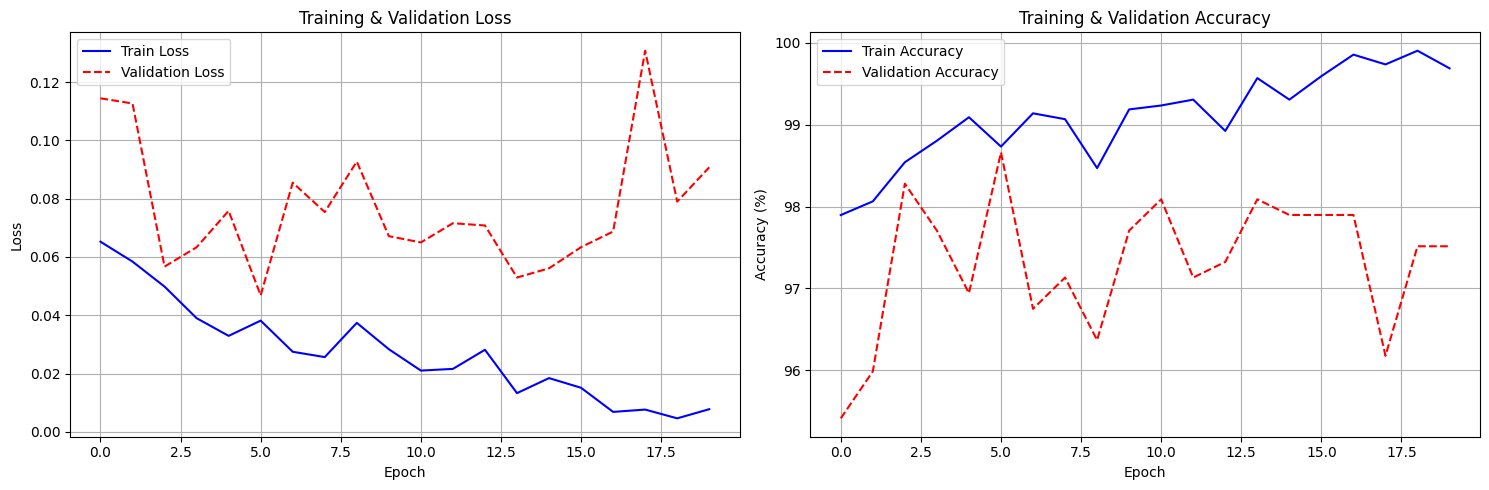

In [ ]:
# Set the size of the figure
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss')  # 'b-' specifies blue color, solid line
plt.plot(val_losses, 'r--', label='Validation Loss')  # 'r--' specifies red color, dashed line
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)  # Add gridlines for better readability
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Train Accuracy')
plt.plot(val_accuracies, 'r--', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

# Ensure a clean layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
cnn_model.eval()
true_labels = []
predicted_labels = []

test_sampler = SubsetRandomSampler(test_indices)
test_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Batch Size: {batch_size}")
print(f"Number of Classes: {num_classes}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Dropout: {dropout}")

print(f"Test Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1 Score: {f1:.6f}")

Batch Size: 32
Number of Classes: 3
Learning Rate: 0.0001
Number of Epochs: 20
Dropout: 0.1
Test Accuracy: 0.957935
Precision: 0.958807
Recall: 0.957935
F1 Score: 0.957961


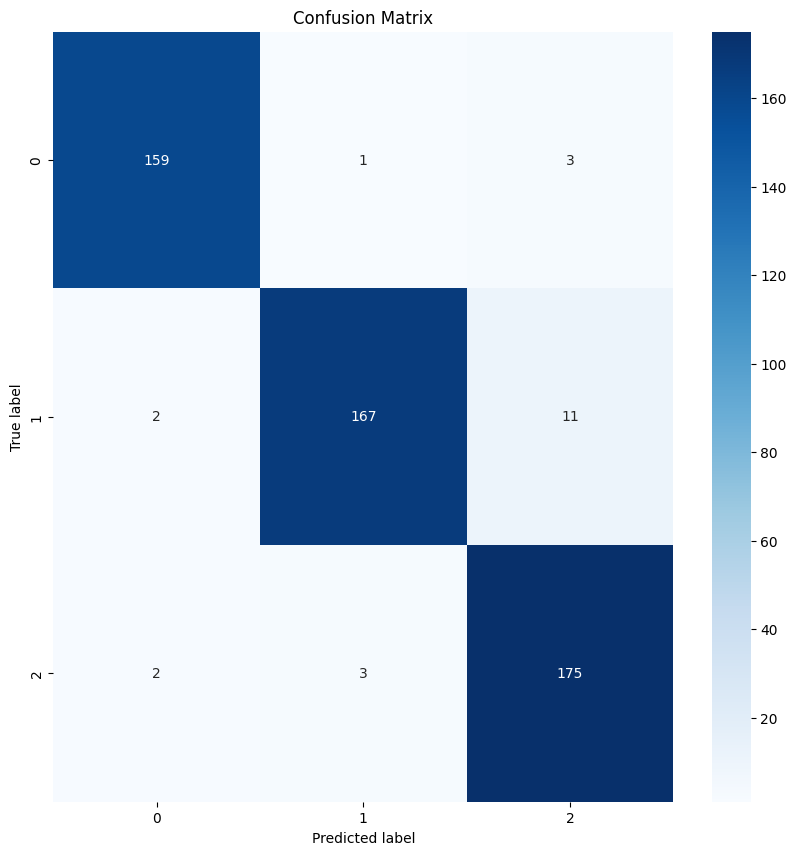

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()